In [1]:
import matplotlib as mpl

mpl.rc('font', size = 6, family='sans-serif')
mpl.rc('text', usetex = True)
mpl.rc('axes', titlesize='8', labelsize='8')
mpl.rc('figure', titlesize='8', labelsize='8')


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.transforms as mtransforms
import numpy as np 
import pandas as pd
from scipy.stats import fisher_exact

from Bio import SeqIO
import re

In [2]:
translation_type = {
    ('m54333U_191207_235415', 1): 'retina',
    ('m54333U_191207_235415', 2): 'muscle',
    ('m54333U_191209_001952', 3): 'brain',
    ('m54333U_191209_001952', 4): 'lung',
    ('m54333U_200119_152035', 1): 'liver',
    ('m54333U_200119_152035', 2): 'heart',
    ('m54333U_200118_085533', 3): 'skin',
    ('m54333U_200118_085533', 4): 'spinal cord',
}

colors = {
    'A': '#0000ff',
    'B': '#ff0000',
    'FI': '#9466bc',
    'BC': '#1f77b3',
    'BI': '#fe7e0d',
    'CIF': '#8c7034',
    'BCI': '#ff0000',
    'I9': '#16becf'
}

type_names = ['a', 'b', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6']

types_order = ['A', 'B', 'BC', 'FI', 'BI', 'BCI', 'CIF', 'I9']

exons_present = {
    'a': [0, 1] + list(range(4, 12)),
    'b': [0, 1, 2] + list(range(4, 12)),
    'n1': list(range(12)),
    'n2': list(range(12)),
    'n3': list(range(12)),
    'n4': list(range(12)),
    'n5': list(range(12)),
    'n6': [0, 1] + list(range(4, 12)),
}

introns = {
    'a': [],
    'b': [],
    'n1': [],
    'n2': [2, 3, 4],
    'n3': [3, 4],
    'n4': [3],
    'n5': [2, 3],
    'n6': [11]
}

def translate_barcode(row):
    name, barcode = row
    file_name = name.split('/')[0]
    bc = 0
    if '12' in barcode:
        bc = 1
    if '13' in barcode:
        bc = 2
    if '14' in barcode:
        bc = 3
    if '15' in barcode:
        bc = 4
    
    return translation_type[(file_name, bc)]

def plot_exons_introns(id, exon_positions, stop_codons, pos, ax):
    prev_end = 0
    type_id = types_order[type_names.index(id)]
    for i, (start, end) in enumerate(exon_positions):
        if i in exons_present[id]:
            if i in [2, 3]:
                ax.add_patch(Rectangle((start, pos-1), end - start, 1, color=colors[type_id]))
            else:
                ax.add_patch(Rectangle((start, pos-1), end - start, 1, color=colors['A']))
        else:
            ax.plot([start, end], [pos-0.5, pos-0.5], color='k', zorder=-1)
        if i in introns[id]:
            ax.add_patch(Rectangle((prev_end + 1, pos-1), start - prev_end - 1, 1, color=colors[type_id]))
        elif i > 0:
            ax.plot([prev_end + 1, start - 1], [pos-0.5, pos-0.5], color='k', zorder=-1)
            
        ax.plot(stop_codons[id], [pos+0.5]*len(stop_codons[id]), 'v', color='k', markersize=1.5, zorder=-1)
        
        prev_end = end

## Cry4 data

In [3]:
cry4_data = pd.read_csv('Cry4.categories.txt', sep='\s+', header=None, names=['id', 'type'])

cry4_barcodes = pd.read_csv('Cry4.barcodes.txt', sep='\s+', header=None, names=['id', 'barcode'])

cry4_barcodes['tissue'] = cry4_barcodes.apply(translate_barcode, axis=1)

cry4_data = pd.merge(cry4_data, cry4_barcodes, how='left', on='id')

exon_positions = pd.read_csv('Cry4.gff', sep='\s+', header=None, names=['chrom', 'source', 'type', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])
exon_positions = exon_positions[(exon_positions['type'] == 'exon') & (exon_positions['attributes'].str.contains('-N1'))]

exon_positions = np.array(exon_positions[['start', 'end']])
exon_positions[:, 1] += 1

exon_lengths = [exon[1] - exon[0] for exon in exon_positions]
exon_lengths, exon_positions

([np.int64(413),
  np.int64(117),
  np.int64(87),
  np.int64(84),
  np.int64(148),
  np.int64(141),
  np.int64(171),
  np.int64(132),
  np.int64(152),
  np.int64(98),
  np.int64(111),
  np.int64(88)],
 array([[198708, 199121],
        [200002, 200119],
        [200654, 200741],
        [201074, 201158],
        [202148, 202296],
        [202552, 202693],
        [203815, 203986],
        [204512, 204644],
        [205077, 205229],
        [206347, 206445],
        [206916, 207027],
        [208663, 208751]]))

In [4]:
stop_codons = {}

for seq in SeqIO.parse('Cry4_all.fasta', 'fasta'):
    translated = str(seq.seq.translate())
    stop_codons[seq.id[4:]] = np.array([m.start() * 3 for m in re.finditer( '\*', translated)])
    
stop_codons

/home/georg/mambaforge/envs/ErCry4b-transcriptome-expression/lib/python3.9/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


{'a': array([1572]),
 'b': array([1659]),
 'n1': array([ 621,  639,  675,  684, 1743]),
 'n2': array([ 531,  615,  819,  822,  879,  981, 1098, 1143, 1299, 1326, 1329,
        1464, 1572, 1596, 1692, 1743, 1749, 1806, 1812, 1857, 1863, 1911,
        1968, 2112, 2169, 2268, 2310, 2319, 2328, 2409, 2565, 2574, 2589,
        2667, 2700, 2727, 2823, 3042, 3156, 3177, 3366, 3444, 3513, 3522,
        3549]),
 'n3': array([ 702,  771,  903,  909,  915,  918,  954,  972, 1008, 1017, 1236,
        1344, 1350, 1566, 1644, 1722, 1758, 1857, 1959, 3066]),
 'n4': array([ 702,  771,  903,  909,  915,  918,  954,  972, 1008, 1017, 2076]),
 'n5': array([ 531,  615,  819,  822,  879,  981, 1098, 1143, 1299, 1326, 1329,
        1464, 1575, 1584, 1599, 1677, 1710, 1737, 1833, 2052, 2166, 2187,
        2376, 2454, 2523, 2532, 2559]),
 'n6': array([1653, 1827, 1878, 1935, 2004, 2010, 2040, 2052, 2091, 2097, 2136,
        2151, 2178, 2361, 2445, 2454, 2532, 2610, 2652, 2661, 2700, 2790,
        2814, 2856, 

In [5]:
for seq in stop_codons:
    stop_codons[seq] = stop_codons[seq] + 198704
    prev_stop = exon_positions[0, 1]
    for i, (start, end) in enumerate(exon_positions):
        if i == 0:
            continue
        if i in introns[seq]:
            prev_stop = end
            continue
        
        stop_codons[seq][stop_codons[seq] >= prev_stop] = stop_codons[seq][stop_codons[seq] >= prev_stop] + start - prev_stop
        
        if i not in exons_present[seq]:
            stop_codons[seq][stop_codons[seq] >= start] = stop_codons[seq][stop_codons[seq] >= start] + end - start

        prev_stop = end
        
        
stop_codons

{'a': array([208748]),
 'b': array([208748]),
 'n1': array([201074, 201092, 201128, 201137, 208748]),
 'n2': array([200116, 200200, 200404, 200407, 200464, 200566, 200683, 200728,
        200884, 200911, 200914, 201049, 201157, 201181, 201277, 201328,
        201334, 201391, 201397, 201442, 201448, 201496, 201553, 201697,
        201754, 201853, 201895, 201904, 201913, 201994, 202150, 202159,
        202174, 202252, 202285, 202568, 202664, 204531, 205078, 205099,
        206406, 206955, 207024, 208669, 208696]),
 'n3': array([200822, 200891, 201023, 201029, 201035, 201038, 201074, 201092,
        201128, 201137, 201356, 201464, 201470, 201686, 201764, 201842,
        201878, 201977, 202079, 208748]),
 'n4': array([200822, 200891, 201023, 201029, 201035, 201038, 201074, 201092,
        201128, 201137, 208748]),
 'n5': array([200116, 200200, 200404, 200407, 200464, 200566, 200683, 200728,
        200884, 200911, 200914, 201049, 202150, 202159, 202174, 202252,
        202285, 202568, 2026

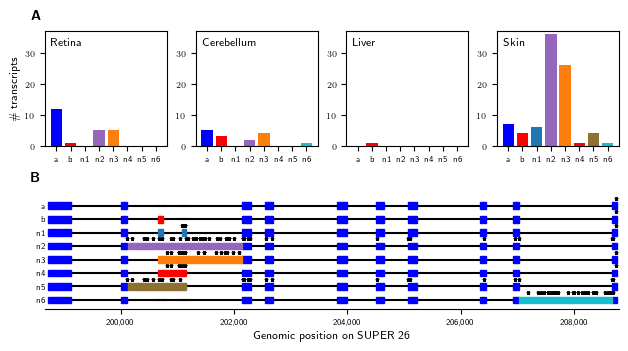

In [6]:
fig, axes = plt.subplot_mosaic([['a', 'a2', 'a3', 'a4'], ['b', 'b', 'b', 'b']])

for label, ax1 in axes.items():
    # label physical distance to the left and up:
    if label in ['legend', 'a2', 'a3', 'a4']:
        continue
    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
    ax1.text(0, 1.0, r'\textbf{' + label.upper() + '}', weight='bold', fontsize=10, transform=ax1.transAxes + trans, va='bottom')

bins = np.arange(0, 84, 8)

ax1 = axes['a']

nums = cry4_data.loc[(cry4_data['tissue'] == 'retina')].groupby('type')['tissue'].count()
for type in types_order:
    if type not in nums.index:
        nums.loc[type] = 0
nums = nums.sort_index(key=lambda x: [types_order.index(y) for y in x])


ax1.bar(type_names, nums, color=[colors[x] for x in nums.index])
ax1.set_title('Retina', y=1.0, pad=-10, x=0.05, ha='left')
ax1.set_ylabel('\# transcripts')
ax1.set_xlabel('')
ax1.set_ylim(0, 37)


ax2 = axes['a2']

nums = cry4_data.loc[(cry4_data['tissue'] == 'brain')].groupby('type')['tissue'].count()
for type in types_order:
    if type not in nums.index:
        nums.loc[type] = 0
nums = nums.loc[types_order]
nums = nums.sort_index(key=lambda x: [types_order.index(y) for y in x])

ax2.bar(type_names, nums, color=[colors[x] for x in nums.index])

ax2.sharex(ax1)
ax2.sharey(ax1)
#ax2.sharey(ax1)
#ax2.sharey(ax1)
ax2.set_title('Cerebellum', y=1.0, pad=-10, x=0.05, ha='left')
ax2.set_xlabel('')

ax3 = axes['a3']

nums = cry4_data.loc[(cry4_data['tissue'] == 'liver')].groupby('type')['tissue'].count()
for type in types_order:
    if type not in nums.index:
        nums.loc[type] = 0
nums = nums.loc[types_order]
nums = nums.sort_index(key=lambda x: [types_order.index(y) for y in x])


ax3.bar(type_names, nums, color=[colors[x] for x in nums.index])

ax3.sharex(ax1)
ax3.sharey(ax1)
ax3.set_title('Liver', y=1.0, pad=-10, x=0.05, ha='left')
ax3.set_xlabel('')
#ax3.set_ylabel('\# transcripts')


ax4 = axes['a4']

nums = cry4_data.loc[(cry4_data['tissue'] == 'skin')].groupby('type')['tissue'].count()
for type in types_order:
    if type not in nums.index:
        nums.loc[type] = 0
nums = nums.loc[types_order]
nums = nums.sort_index(key=lambda x: [types_order.index(y) for y in x])

ax4.bar(type_names, nums, color=[colors[x] for x in nums.index])

#ax4.sharex(ax1)
ax4.sharey(ax1)
ax4.set_title('Skin', y=1.0, pad=-10, x=0.05, ha='left')
ax4.set_xlabel('')


ax = axes['b']

#ax.plot(polypyr['pos'], polypyr['polypyr'] + 1.2, label='PolyPyr')
#ax.plot(branch_sites['pos'], branch_sites['branch_site'] + 2, label='Branch site')

exon_positions_a = np.concatenate((exon_positions[:2], exon_positions[4:]), axis=0)

# Cry4a
pos = 1

plot_exons_introns('a', exon_positions, stop_codons, pos, ax)


#Cry4b
pos = -1


plot_exons_introns('b', exon_positions, stop_codons, pos, ax)

#Cry4bc
pos = -3

plot_exons_introns('n1', exon_positions, stop_codons, pos, ax)


#Cry4 intron
pos = -5

plot_exons_introns('n2', exon_positions, stop_codons, pos, ax)

#Cry4 b intron
pos = -7

plot_exons_introns('n3', exon_positions, stop_codons, pos, ax)


#Cry4 bc intron
pos = -9

plot_exons_introns('n4', exon_positions, stop_codons, pos, ax)


pos = -11


plot_exons_introns('n5', exon_positions, stop_codons, pos, ax)


pos = -13

plot_exons_introns('n6', exon_positions, stop_codons, pos, ax)



ax.spines[['right', 'top', 'left']].set_visible(False)
ax.set_yticks([])

for pos, text in zip(range(1, -14, -2), type_names):
    ax.annotate(text, (exon_positions[0][0] - 40, pos - 0.5), ha='right', va='center')

ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_xlabel('Genomic position on SUPER 26')
ax.set_xlim(exon_positions[0][0] - 40, exon_positions[-1][1] + 40)

fig.set_size_inches(6.268, 3.5)
fig.tight_layout()
fig.savefig('Transcriptome.pdf')

In [7]:
retina_counts = cry4_data.loc[(cry4_data['tissue'] == 'retina')].groupby('type')['tissue'].count()
for type in types_order:
    if type not in retina_counts.index:
        retina_counts.loc[type] = 0
retina_counts = retina_counts.loc[types_order]
retina_counts = retina_counts.sort_index(key=lambda x: [types_order.index(y) for y in x])

for tissue in ['lung', 'spinal cord', 'brain', 'heart', 'skin']:
    nums = cry4_data.loc[(cry4_data['tissue'] == tissue)].groupby('type')['tissue'].count()
    for type in types_order:
        if type not in nums.index:
            nums.loc[type] = 0
    nums = nums.loc[types_order]
    nums = nums.sort_index(key=lambda x: [types_order.index(y) for y in x])
    
    mat = np.array([[retina_counts['A'], retina_counts[retina_counts.index != 'A'].sum()],
                    [nums['A'], nums[nums.index != 'A'].sum()]])
    res = fisher_exact(mat)
    
    print(f'p-value retina - {tissue}: {res.pvalue:.2}')
    

p-value retina - lung: 1.0
p-value retina - spinal cord: 0.69
p-value retina - brain: 0.33
p-value retina - heart: 0.4
p-value retina - skin: 1.1e-05
